# Sensitivity, power, reproducibility

As we saw in the lecture, the concepts of sensitivity and power are concerned with controlling the rate of type I and type II errors respectively, where type I errors are false positives and type II errors are false negatives.

<img src="images/t1t2_error.png" width=80% >

Think about it this way:
* When we are talking about sensitivity (controlling type I errors) we are proposing that the true population effect is zero (say, correlation and we are interested in the probability of obtaining a certain value of a test statstistic (say, correlation r=0.25) due to chance.
* When we are talking about power (controlling type II errors) we are proposing that the true populaiton effect is non-zero (say correlation and we are interested in how frequently we fail to reject the null hypothesis.



### Set up Python libraries

As usual, run the code cell below to import the relevant Python libraries

In [1]:
# Set-up Python libraries - you need to run this but you don't need to change it
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas 
import seaborn as sns

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Power of a Correlation

I collect data on end-ofyear exam scores in Maths and French for 50 high school studehts. Then I calculate the correlation coefficient, Pearson's r, between Maths and French scores across my sample of 50 participants.

* I observe a correlation of r=0.25 

Can I trust this result? 

### Eyeballing the data

What does a correlation of 0.25 look like for 50 data points?
Here are some examples of datasets that actually have r=0.25:

<img src="images/r25_examples.png" width=100% >

Would you trust those correlations?

## Specificity

A Type 1 error occurs when the null hypothesis is true (as it is for our simulated population with zero correlation), but is nonetheless rejected.

The specificity of a test is the probability of avoiding a Type 1 Error, if the null is true. So say the null hypothesis is true and we test at the $\alpha$=0.05 level. The probability of a Type 1 error is (by definition) 5% and the specificity of the test is 95%.

In this section we check that we do indeed get a false positive (ie a Type 1 error) 5% of the time when testing at the $\alpha$=0.05 level in a population here the null is true. 

#### Our example:

* $\mathcal{H_0}$ Under the null hypothesis there is no correlation between maths scores and French scores
* $\mathcal{H_a}$ Under the alternative hypothesis, there is a correlation

Let's start by generating a large dataset with 25000 pairs in it (so 2 columns, 25000 rows), with a correlation between columns of zero. Don't worry too much about this code block as you will not be asked to replicate this by yourself.

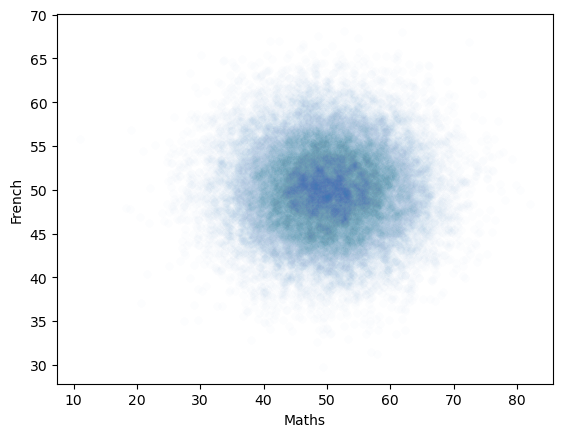

In [2]:
# Code to generate the population with zero correlation - don't worry about understanding this bit

rho=0 # the desired correlation

# desired mean and sd of variables in columns 0 and 1
m0=50
m1=50
s0=8
s1=5

c=[[1,rho],[rho,1]] # the correlation matrix that we want in the simulated dataset

# make two columns of numbers with the desired correlation (mean of each column is zero, sd is 1)
tmp=np.random.multivariate_normal([0,0],c,size=25000)

# scale the variables to get correct mean and sd
tmp[:,0]=(tmp[:,0]*s0)+m0
tmp[:,1]=(tmp[:,1]*s1)+m1
pop_rZero=pandas.DataFrame(tmp,columns=['Maths','French'])

# plot scatterplot
sns.scatterplot(data=pop_rZero,x='Maths',y='French',alpha=0.01)
plt.show()

The generated dataset has two columns and 25,000 rows. 

The correlation between the two columns should be close to the <tt>r</tt> value we set, ie zero. 

The scatterplot definitely looks like there is no correlation!

In [3]:
# check that the actual correlation is in the 10000 simulated samples
pop_rZero.corr()

,Maths,French
Maths,1.000000,-0.002274
French,-0.002274,1.000000


### Specificity or probability of a Type 1 error

A Type 1 error occurs when the null hypothesis is true (as it is for our simulated population with zero correlation), but is nonetheless rejected.

If I choose an alpha value of 0.05, this means I would reject the null hypothesis if the $p$-value for my obtained correlation is less than 0.05.

By definition, for random samples from a population with no correlation, this should happen 5% of the time.

#### How to we get the p-value for a correlation?

For a given values of Pearson's $r$, we can work out a t-score using the equation:

$$ t=\frac{r}{\sqrt{(1-r^2)(n-2)}} $$

and then the p value is obtained from the $t_{n-2}$ distribution.

However you can get straight to the $p$-value by using <tt>scipy.stats</tt> - note that we are using <tt>scipy.stats</tt> as the other correlation functions we met in <tt>numpy</tt> and <tt>pandas</tt> do not return a $p$-value.

For example:

In [4]:
sample = pop_rZero.sample(n=50)
stats.pearsonr(sample['Maths'], sample['French'], alternative='greater')

PearsonRResult(statistic=0.1958487861830906, pvalue=0.08642940113159897)

... and to return just the p-value as a single number:

In [5]:
stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue

0.08642940113159897

#### Back to probability of a Type 1 errror

Let's try drawing 10000 samples from our no-correlation population and see how often we do get a significant result!

In [6]:
nReps=10000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rZero.sample(n=sampleSize)
    p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue
    
# How many of our 10000 sammples had p<0.05?
np.mean(p<0.05)

0.0465

Hopefully the proportion of samples from the no-correlation distribution with p<0.05 is about.... 0.05. 

## Power

A Type 2 error occurs hen the alternative hypothesis is true, but we fail to reject the null.

The probability of correctly rejecting the null when $\mathcal{H_a}$ is true is the sensitivity or power of a test. So if the probability of a Type 2 error for a given test is 20%, the sensitivity or power of the test is 80%.

### Power by simulation

We can investigate power in our correlation example using the same simulation approach as above, but now we need to <i>assume the true population correlation $\rho$ is 0.25<i>

First, I'm going to generate a population (25 000 pairs of values) in which the true correlation between two variables (let's call them 'anxiety' and 'risk aversion') is 0.25. Again don't worry too much about understanding this code block.

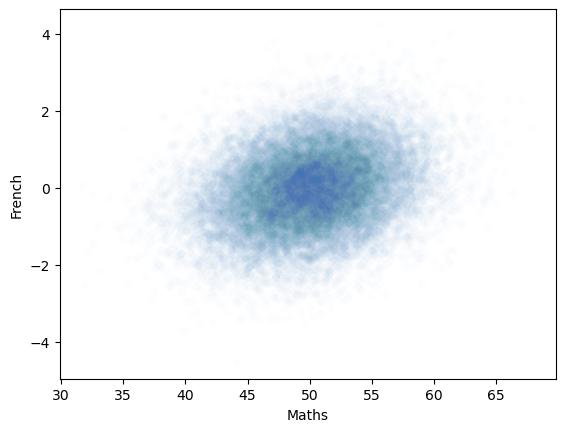

In [7]:
# Code to generate the population with a correlation of rho - don't worry about understanding this bit

rho=0.25 # the desired correlation

# desired mean and sd of variables in columns 0 and 1
m0=50
m1=0
s0=4.5
s1=1

c=[[1,rho],[rho,1]] # the correlation matrix that we want in the simulated dataset

# make two columns of numbers with the desired correlation (mean of each column is zero, sd is 1)
tmp=np.random.multivariate_normal([0,0],c,size=25000)

# scale the variables to get correct mean and sd
tmp[:,0]=(tmp[:,0]*s0)+m0
tmp[:,1]=(tmp[:,1]*s1)+m1
pop_rNonZero=pandas.DataFrame(tmp,columns=['Maths','French'])

# plot scatterplot
sns.scatterplot(data=pop_rNonZero,x='Maths',y='French',alpha=0.01)
plt.show()

Hopefully the scatterplot shows some data with a weak correlation (the datapoints are no longer spread on a circle, but stretched into an oval shape). 

We can check the correlation in the full population of 25000 samples, hopefully this should be close to 0.25.

In [8]:
pop_rNonZero.corr()

,Maths,French
Maths,1.000000,0.258352
French,0.258352,1.000000


The question for our *power analysis* is, for samples of size n=50, what proportion of the time will I obtain a significant correlation (reject the null)?

To answer that question I am going to draw samples of size 50 from the population *which actually has $r$=0.25* and obtain the sample correlation for each of those samples and its p value using <tt>scipy.stats</tt>. I can then ask in what proportion of simulated samples $p<0.05$, ie in what proportion of the simulated samples we manage to reject the null.

In [9]:
nReps=1000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rNonZero.sample(n=sampleSize)
    p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater')
    
# How many of our 10000 samples had p<0.05?
np.mean(p<0.05)

ValueError: setting an array element with a sequence.

In my simulation I manage to reject the null in about 41% of simulations (note the exact value you get will vary slightly each time you run the simulation). So my test has a power of 41%


<img src="images/Minion_what.jpg" width=15% >

Yes, that's right. In a population where the *true* correlation between two variables (scores on Maths and French tests) is 0.25, for samples of size 50, I will fail to detect a significant correlation (ie, I will make a Type 2 error) over half the time.

This would be true for any data with a true correlation of 0.25 and sample size of 50 - $n$=50 is really not enough to detect a weakish correlation.

Try changing $n$ in the code block below to be smaller (eg $n$=25) or larger ($n$=150) and see what happens to the power.

In [15]:
nReps=1000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rNonZero.sample(n=sampleSize)
    p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue
    
# How many of our 10000 samples had p<0.05?
np.mean(p<0.05)

0.445

## Sample size

We have just seen that a large sample size is needed to get good power for a weak correlation. In general, the power of a test (1 - chance of a Type 2 error) increases with $n$ whilst the specificity (1 - chance of a type 1 error) does not. Why?

#### The probability of a Type 1 error does not depend on sample size

Statistical tests are designed to control the probability of a type 1 error. When calculating the critical value of the test statistic (in the case of correlation, the test statistic is $r$ and the critical value is minimum $r$ value that would be considered significant for a given sample size $n$, $n$ is directly taken into account. Therefore, the probably of a type 1 error is fixed regardless of sample size.

#### The probability of a Type 1 error *does* depend on sample size

The above is *not* true for type 2 error. The probability of Type 2 error (and hence the power of the test) varies with sample size.

If we increase the sample size, the power of the test increases.

Let's try it! Change the sample size in the code block below to 10,100 and 1000. How does the power change


In [17]:
nReps=1000
sampleSize=50
p = np.empty(nReps)

for i in range(nReps):
    sample = pop_rNonZero.sample(n=sampleSize)
    p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue
    
# How many of our 10000 samples had p<0.05?
print('power = ' + str(100*(np.mean(p<0.05))) + '%')

power = 41.9%


We can loop over different sample sizes and plot how power increases as sample size increases:

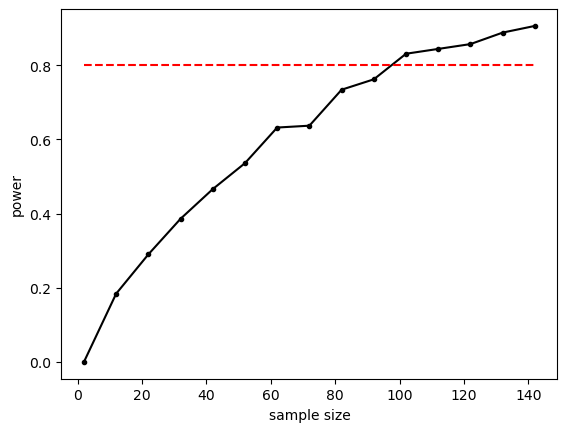

In [29]:
n=range(2,150,10)
power = np.empty(len(n))

for s in range(len(n)):
    nReps=1000
    p = np.empty(nReps)
    sampleSize=n[s]

    for i in range(nReps):
        sample = pop_rNonZero.sample(n=sampleSize)
        p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue
    
    power[s]=np.mean(p<0.05)
    
# plot the results
plt.plot(n,power,'k.-')
plt.plot([min(n),max(n)],[0.8,0.8],'r--') # reference line for 80% power
plt.xlabel('sample size')
plt.ylabel('power')
plt.show()

The relationship between sample size and power is slightly bumpy as we checked only 1000 simulated samples at each sample size. If you increased nReps to 10,000 the curve would look smoother (but the simulation ould take a long time to run).

Conventionally a power of 80% (indicated by the red dashed line on the graph) is considered desirable. What sample size do we need to get power of 80%? It looks from the graph like you would need around n=120. Let's re-run a finer grained simulation in that range:



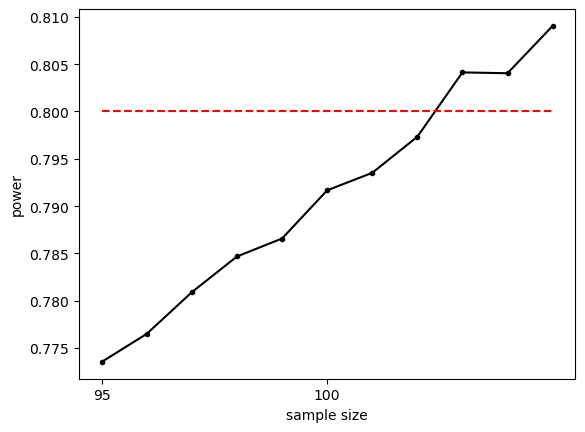

In [31]:
n=range(95,106)
power = np.empty(len(n))

for s in range(len(n)):
    nReps=100000
    p = np.empty(nReps)
    sampleSize=n[s]

    for i in range(nReps):
        sample = pop_rNonZero.sample(n=sampleSize)
        p[i] = stats.pearsonr(sample['Maths'], sample['French'], alternative='greater').pvalue
    
    power[s]=np.mean(p<0.05)
    
plt.plot(n,power,'k.-')
plt.plot([min(n),max(n)],[0.8,0.8],'r--') # reference line for 80% power
plt.xlabel('sample size')
plt.ylabel('power')
plt.xticks(range(min(n),max(n),5))
plt.show()

# Power calculations in practice

Power is defined as the proportion of the time we would expect to get a statistically significant effect in samples of size $n$, given that there is a true effect of a certain size (for example $r$=0.25) in the population. 

An obvious problem with this is that in a real experiment you wouldn't know the true effect sizze in the underlying population - that is what you are trying to measure! So how can you calculate the power for a given planned sample size, or the sample size needed to achieve 80% power, in advance? 

Unfortunately, it is often impossible to have an accurate estimate of the expected effect size in advance. Sometimes we can estimate the effect size (such as the correlation in the underlying population) from looking at similar studies in the literature, but usually such guesses will give only a very rough estimate of the effect size that will arise in our planned experiment. An alternative is to conduct a pilot experiment to determine effect size - this is more likely to be practical in the context of a large study (such as a drug trial) than a small-scale experiment (such as an undergraduate psychology project).


### Clinically significant effect size

One context in which power can definitely be meaningfully defined, is when we kno hat size of effect we would *care about*, even if we don't know what the underlying effect size in the population is. 

Say for example we are testing a new analgesic drug. We may not kno how much the drug will ruduce pain scores (the true effect sizze) but we can certainly define a minimum effect size that would be clinically meaningful You could say that you would only consider the effect of the drug clinically significant if there is a 10% change in pain scores (otherwise, the drug won't be worth taking). That is different from statstistical significance - if you test enough patients you could detect a statstically significant result even for a very small change in clinical outcome but it still wouldn't mean your drug is an effective painkiller.

If we conduct a power analysis assuming that the effect size in the population is the minimmum clincally significant effect, this will tell us how many participants we need to detect such a clinically significant effect with (say) 80% power. By definition a smaller effect would need more participants to detect it (but we wouldn't be interested in such a small effect from a clinical perspective, so that doesn't matter). Any effect larger than the minimum clinically significant effect ould have more than 80% power, as larger effects are easier to detect.

# Power of a t-test

Let us now look at power analysis for a t-test for difference of means.

A researcher hypothesises that geography students are taller than psychology students.

$\mathcal{H_o}:$ The mean heights of psychology ($\mu_p$) and geography ($\mu_g$) students are the same; $\mu_p = \mu_g$

$\mathcal{H_a}:$ The mean heights of geography students is greater than the mean height of psychology students; $\mu_g > \mu_p$


He measures the heights of 12 geography students an 10 psychology students, which are given in the dataframe below:

In [47]:
heights=pandas.read_csv('data/PsyGeogHeights.csv')
heights

,studentID,subject,height
0,186640,psychology,154.0
1,588140,psychology,156.3
2,977390,psychology,165.6
3,948470,psychology,162.0
4,564360,psychology,162.0
5,604180,psychology,159.0
6,770760,psychology,166.1
7,559170,psychology,165.9
8,213240,psychology,163.7
9,660220,psychology,165.6


Let's calculate the sample mean for each subject group:

In [48]:
heights.groupby('subject')['height'].mean()

subject
geography     168.460
psychology    163.325
Name: height, dtype: float64

... and conduct a t-test to see if the difference of means is significant:

In [94]:
psy = heights[heights['subject']=='psychology']['height']
geog = heights[heights['subject']=='geography']['height']

stats.ttest_ind(geog,psy,alternative='greater')

Ttest_indResult(statistic=1.7743564827449236, pvalue=0.04561467878556142)

The difference is *just* significant at $\alpha$=0.05 - our $p$-value is 0.0456

## Effect size

The mean height of the geography students is 5.14 cm greater than the mean height of the psychology students

Is this a large difference? Would it be obvious in a psychology-geography student party who is a psychology student and who is a geography student, just from their heights? 

We can visualise how much the populations overlap by plotting them:

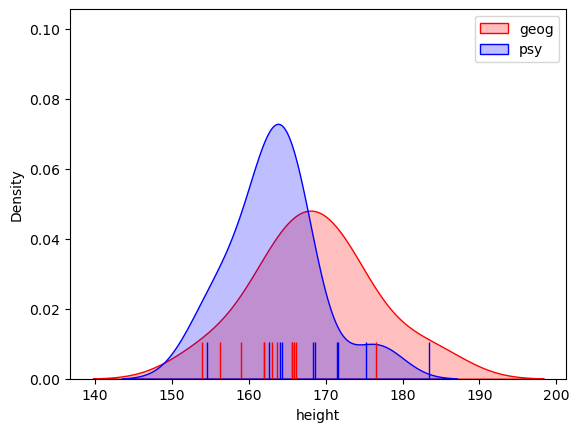

In [81]:
# plot KDEs
sns.kdeplot(data=geog, color=[1,0,0], shade=True)
sns.kdeplot(data=psy, color=[0,0,1], shade=True)
# plot datapoints
sns.rugplot(data=geog, color=[0,0,1], height=0.1)
sns.rugplot(data=psy ,color=[1,0,0], height=0.1)

plt.legend({'geog','psy'})
plt.show()

Hm, no, we probably could not tell who is a psychology student and who is a geography student, just from their heights, but it looks like there is a difference between the groups overall.

We can quantify the size of the difference as:

$$ d = \frac{\bar{x_g}-\bar{x_p}}{s} $$

where:
* $\bar{x_g}$ is the mean height of our sample of geography students
* $\bar{x_p}$ is the mean height of our sample of psychology students
* $s$ is the *shared standard deviation estimate* basaed on the standard deviations of the samples, $s_p$ and $s_g$:

$$ s = \sqrt{\frac{(n_p-1)s_p^2 + (n_g-1)s_g^2)}{n_p + n_g - 2}} $$

oof!


Let's implement that:

In [79]:
# calculate shared standard deviation s

xP = psy.mean()
xG = geog.mean()

sP = psy.std()
sG = geog.std()

nP = psy.count()
nG = geog.count()

s=(((nP-1)*(sP**2) + (nG-1)*(sG**2))/(nP+nG-2))**0.5 # **0.5 means 'to the power of a half' ie square root
s

6.758944074335872

$s$ is an estimate of the standard deviation of heights, based on both groups, so it should be similar to the standard deviation of each of the individual groups.

Now we can calculate our effect size:

In [68]:
# Cohen's d
d=(xG-xP)/s
d

0.7597340566106963

So the difference in mean heights between psychology and geography students is 0.76 standard deviations.

Note that in dividing the difference by the standard deviations, we are quantifying the overlap between the two distributions independent of the data values themselves - for example here are another dataset with the same effect size:

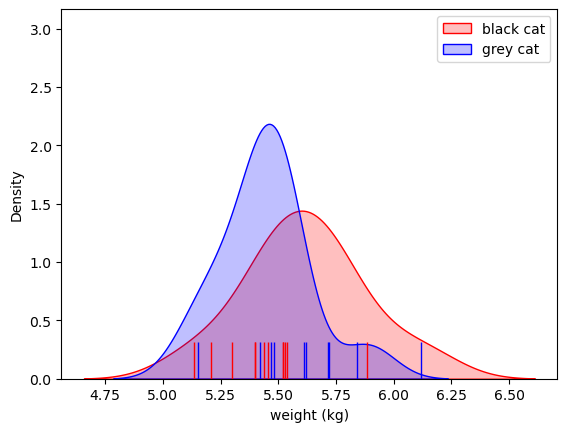

In [75]:
cats=pandas.read_csv('data/catWeights.csv')
# plot KDEs
sns.kdeplot(data=cats[cats['fur']=='black']['weight'],color=[1,0,0], shade=True)
sns.kdeplot(data=cats[cats['fur']=='grey']['weight'],color=[0,0,1], shade=True)
# plot datapoints
sns.rugplot(data=cats[cats['fur']=='black']['weight'],color=[0,0,1], height=0.1)
sns.rugplot(data=cats[cats['fur']=='grey']['weight'],color=[1,0,0], height=0.1)

plt.legend({'black cat','grey cat'})
plt.xlabel('weight (kg)')
plt.show()

It's more striking if you see them on the same axis:

Hence we can this of our effect size is a 'pure' measure of the overlap between the groups.

### Power: Simulate a dataset with $d = 0.760$

We are assuming the data are normally distributed so if we create two datasets that are normally distributed with a standard deviation of 1, and a difference of means of 0.760, they will have an effect size for difference of means of $d = 0.760$

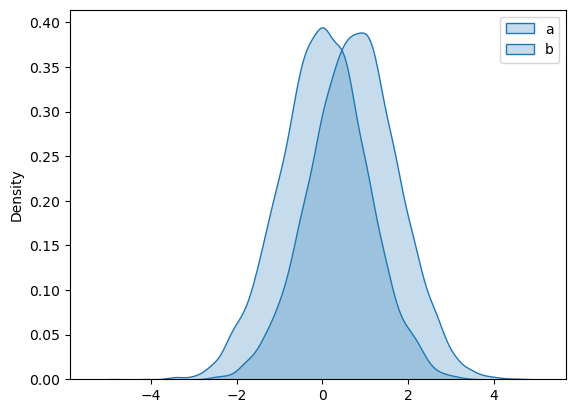

In [93]:
a = np.random.normal(0,1,(10000,1))
b = np.random.normal(0.760,1,(10000,1))

sns.kdeplot(data=a, color=[1,0,0], shade=True)
sns.kdeplot(data=b, color=[0,0,1], shade=True)

plt.legend({'a','b'})
plt.show()

### Draw 10000 random samples and see how often we get a significant effect

Now we simulate drawing many samples from our population with $d=0.760$, conducting an independent samples t-test on each one, and counting what proportion are significant.

In [121]:
nReps = 10000
pVals = np.empty(nReps)

for i in range(nReps):
    sample_a=a[np.random.choice(len(a), size=12, replace=False)] # pick 12 random datapoints from a
    sample_b=b[np.random.choice(len(b), size=8, replace=False)] # pick 8 random datapoints from b
    
    pVals[i] = stats.ttest_ind(sample_b, sample_a, alternative='greater').pvalue # t-test on my random samples
    
power = np.mean(pVals<0.05) # count proportion of p values that are <0.05
print('power = ' + str(power*100) + '%')

power = 46.910000000000004%


The power is 46.9% which means if there is a real effect of size $d=0.760$, with the sample sizes of 12 and 8, we would detect it about 47% of the time.

If we increased the sample sizes, the power would increase:

In [117]:
# increase sample sizes from 12 and 8, to 120 and 80
nReps = 10000
pVals = np.empty(nReps)

for i in range(nReps):
    sample_a=a[np.random.choice(len(a), size=120, replace=False)] # pick 12 random datapoints from a
    sample_b=b[np.random.choice(len(b), size=80, replace=False)] # pick 8 random datapoints from b
    
    pVals[i] = stats.ttest_ind(sample_b, sample_a, alternative='greater').pvalue
    
power = np.mean(pVals<0.05)
print('power = ' + str(power*100) + '%')

## Built in function for power

There is a built in function in a package called `statsmodels` for doing power analysis.

You can use it to find the power for a given sample size:

In [5]:
# import required modules
from statsmodels.stats.power import TTestIndPower
    
# perform power analysis to find sample size 
# run the power analysis relating alpha, d, n1, n2 
analysis = TTestIndPower()

# solve for sample size
power = analysis.solve_power(effect_size=0.760, alpha=0.05, nobs1=8, ratio=12/8, power=None, alternative='larger')
    
print('power = ' + str(power*100) + '%')

power = 48.29582456481827%


This is hopefully not a bad match to our homemade code above (it won't be a perfect match as our homemade one is based on random sampling)

Instead of calculating the power for a given sample size, we can calculate the sample size required to achieve a given power (say 80%). As our samples are independent and have different sizes, we assumme the ratio is fixed (12 psychology students to 8 geography, or 120 psychology to 80 geography):

In [6]:
# solve for sample size
n1 = analysis.solve_power(effect_size=0.760, alpha=0.05, nobs1=None, ratio=12/8, power=0.8, alternative='larger')
  
print('required sample size: n1 = ' + str(n1) + '; n2 = ' + str(n1*12/8))

required sample size: n1 = 18.405740901828487; n2 = 27.60861135274273


The syntax for the power analysis is a bit fiddly so let's recap it:

There is a four way relationship between:
  * sample size(s) (`nobs`)
  * alpha values (`alpha`)
  * effect size (`effect size`)
  * power

If we know three of them, we can work out the fourth.

... note that we specify the samples size thus:
   * size of group 1 is `nobs`
   * `ratio` tells us the ratio n2/n1
   
#### Running it   

When we run power analysis using `TTestIndPower` we first run an analysis that models the relationship between the four factors for the test in question (independent samples t-test in this case, but it could have been a paired t-test, or something else that we haven'e met yet like an ANOVA or Chi Square test):

In [ ]:
analysis = TTestIndPower()

Then we solve the equations, giving the computer three out of the four values and setting the fourth to `None`:

In [11]:
# solve for power
power = analysis.solve_power(effect_size=0.760, alpha=0.05, nobs1=8, ratio=12/8, power=None, alternative='larger')
print('power = ' + str(power*100) + '%')

# solve for sample size
n1 = analysis.solve_power(effect_size=0.760, alpha=0.05, nobs1=None, ratio=12/8, power=0.8, alternative='larger')
print('required sample size: n1 = ' + str(n1) + '; n2 = ' + str(n1*12/8))

# what alpha value would you need to use to have a power of 80% with the sammple sizes 8,12?
# solve for sample size
alpha = analysis.solve_power(effect_size=0.760, alpha=None, nobs1=8, ratio=12/8, power=0.8, alternative='larger')
print('required alpha = ' + str(alpha))

power = 48.29582456481827%
required sample size: n1 = 18.405740901828487; n2 = 27.60861135274273
required alpha = 0.20952367203411126


### Note on effect size

In this case we worked out the effect size in our actual sample of 12 psychologists and 8 geographers, as 0.760, and conducted a power analysis using that effect size. This is sometimes called a post-hoc power analysis. It told us that we should have tested 19 and 28 people rather than 12 and 8. This isn't quite the intended purpose of poewr analysis (to work out the required sample size in advance) but is how power analysis is often used in reality - to evaluate post hoc, or after the fact, whether a study was sufficiently well powered.

# Paired sample t-test

There is a version of the power analysis for paired samples t-test (indeed, there are versions for various analyses, although not for correlation annoyingly).

The version for paired samples t-test is called `TTestPower()` as opposed to `TTestIndPower`

See if you can work out how to use this to find the sample size required for 80% power for an effect size of $d=0.5$, testing at $\alpha$=0.05.

In [9]:
# import required modules
from statsmodels.stats.power import TTestPower

# run an analysis that models the relationship between the four factors 
analysis = # your code here

# solve for n
# your code here

SyntaxError: invalid syntax (3955565404.py, line 5)

#### another example 

... think back to how we calculated d, see if you can run one from the raw data. 

Let's look at the brother-sister heights data.

In [20]:
heights=pandas.read_csv('data/BrotherSisterData.csv')
heights

,brother,sister
0,174,172
1,183,180
2,154,148
3,172,180
4,172,165
5,161,159
6,167,159
7,172,164
8,195,188
9,189,175


conduct a paired t-test to see if brothers are taller than sisters - it's highly significant

In [22]:
stats.ttest_rel(heights['brother'],heights['sister'])

TtestResult(statistic=5.742269354639271, pvalue=6.442462549436049e-06, df=24)

We need to calculate $d$ as:

$$ d = \frac{\bar{x_b}-\bar{x_s}}{s} $$

where:
* $\bar{x_b}$ is the mean height of our sample of brothers
* $\bar{x_s}$ is the mean height of our sample of sisters
* $s$ is the *shared standard deviation estimate* basaed on the standard deviations of the samples, $s_b$ and $s_s$:

$$ s = \sqrt{\frac{(n_b-1)s_bb^2 + (n_g-1)s_s^2)}{n_b + n_s - 2}} $$

In [ ]:
# your code here

The we can run the power model for the paired test, and solve for power:

In [ ]:
# import required modules
from statsmodels.stats.power import TTestPower

# run an analysis that models the relationship between the four factors 
analysis = # your code here

# solve for power
# your code here